In [24]:
import os,warnings,random,shutil
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import MobileNetV2

import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:10<00:00, 56.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [3]:
data_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'

In [4]:
# Define paths
raw_img_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'
output_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/output'

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create output directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [5]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Iterate through each class directory
for class_name in os.listdir(raw_img_dir):
    class_dir = os.path.join(raw_img_dir, class_name)

    # Skip non-directory items
    if not os.path.isdir(class_dir):
        continue

    # Collect image filenames
    image_filenames = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Shuffle the filenames
    random.shuffle(image_filenames)

    # Split the filenames into train, validation, and test sets
    train_files, temp_files = train_test_split(image_filenames, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Create class directories in train, val, and test folders
    for dir_path in [train_dir, val_dir, test_dir]:
        class_output_dir = os.path.join(dir_path, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

    # Copy files to the respective directories
    for file_list, target_dir in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
        for filename in file_list:
            src_path = os.path.join(class_dir, filename)
            dst_path = os.path.join(target_dir, class_name, filename)
            shutil.copy(src_path, dst_path)

In [6]:
# Define parameters
img_height = 160
img_width = 160
batch_size = 32

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [7]:
# Define data directories
train_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/output/train'
val_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/output/val'
test_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/output/test'

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load validation data
valid_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load test data (optional)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 18321 images belonging to 10 classes.
Found 5234 images belonging to 10 classes.
Found 2624 images belonging to 10 classes.


In [8]:
# model = tf. keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(10, activation='softmax') # Sigmoid for binary class, softmax for multi class
# ])

# Create model
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(160,160, 3)
)

# Freeze the base model initially
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,        # Reduced patience
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,       # More aggressive LR reduction
        patience=2,       # Reduced patience
        min_lr=0.0001
    )
]

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.8020 - loss: 0.7141 - val_accuracy: 0.9199 - val_loss: 0.3194 - learning_rate: 0.0100
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.8718 - loss: 0.4143 - val_accuracy: 0.9219 - val_loss: 0.3774 - learning_rate: 0.0100
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - accuracy: 0.8856 - loss: 0.3853 - val_accuracy: 0.9245 - val_loss: 0.3325 - learning_rate: 0.0100
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 572s 998ms/step - accuracy: 0.9072 - loss: 0.3110 - val_accuracy: 0.9385 - val_loss: 0.2214 - learning_rate: 0.0050
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 603s 965ms/step - accuracy: 0.9152 - loss: 0.2796 - val_accuracy: 0.9410 - val_loss: 0.1965 - learning_rate: 0.0050
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - accuracy: 0.9203 - loss: 0.2617 - val_accuracy: 0.9253 - val_loss: 0.2733 - learning_rate: 0.0050
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.9195 - lo

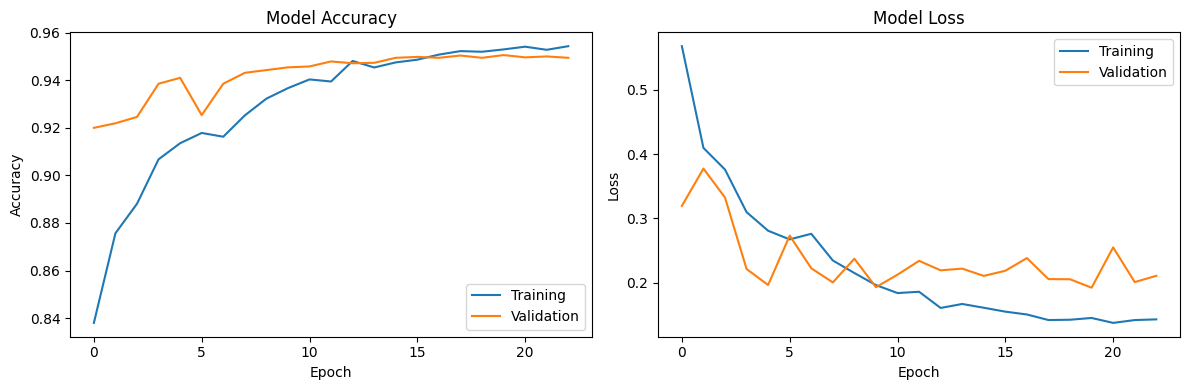

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# plt.savefig('training_history.png')
plt.show()

In [13]:
# Evaluate the model on the training generator
train_loss, train_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=2)

print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

82/82 - 50s - 604ms/step - accuracy: 0.9463 - loss: 0.1991
Training Loss: 0.19907616078853607
Training Accuracy: 0.9462652206420898


In [20]:
pip freeze > requirements.txt

In [19]:
import pathlib

export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

with open('label.txt', 'w') as f:
    # Write your labels here
    f.write('''
    translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}
    ''')

In [17]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 24.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [15]:
model.save('model.h5')

In [18]:
pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-02-21 05:03:48.747922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740114228.789639   65531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740114228.802531   65531 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
